In [ ]:
# default_exp data.preparation

# Data preparation

> Functions required to prepare X (and y) from a pandas dataframe.

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.data.validation import *

In [ ]:
#export
def df2xy(df, sample_col=None, feat_col=None, step_col=None, data_cols=None, target_col=None, to3d=True, splits=None, sort=False):
    r"""
    This function allows you to transform a pandas dataframe into X and y numpy arrays that can be used to craete a TSDataset.
    sample_col: column that uniquely identifies each sample.
    feat_col: used for multivariate datasets. It indicates which is the column that indicates the feature by row.
    step_col: used to indicate the order of the (time)steps when indicated in a column. It's only used to order data.
    data_col: indicates ths column/s where the data is located. If None, it means all columns (except the sample_col, feat_col, step_col and target_col)
    target_col: indicates the column/s where the target is.
    to3d: turns X to 3d (including univariate time series)
    sort: indicates whether the df needs to be sorted or not. If sorted, it will use sample col first, and feat_col second. For more complex sorting
          you'll need to pass a pre-sorted dataframe.
    """
    if feat_col is not None:
        assert sample_col is not None, 'You must pass a sample_col when you pass a feat_col'

    passed_cols = []
    sort_cols = []
    if sample_col is not None: 
        if isinstance(sample_col, pd.core.indexes.base.Index): sample_col = sample_col.tolist()
        sample_col = listify(sample_col)
        passed_cols += sample_col
        sort_cols += sample_col
    if feat_col is not None: 
        if isinstance(feat_col, pd.core.indexes.base.Index): feat_col = feat_col.tolist()
        feat_col = listify(feat_col)
        passed_cols += feat_col
        sort_cols += feat_col
    if step_col is not None: 
        if isinstance(step_col, pd.core.indexes.base.Index): step_col = step_col.tolist()
        step_col = listify(step_col)
        passed_cols += step_col
        sort_cols += step_col
    if data_cols is not None: 
        if isinstance(data_cols, pd.core.indexes.base.Index): data_cols = data_cols.tolist()
        data_cols = listify(data_cols)
        passed_cols += data_cols
    if target_col is not None: 
        if isinstance(target_col, pd.core.indexes.base.Index): target_col = target_col.tolist()
        target_col = listify(target_col)
        passed_cols += target_col

    if data_cols is None:
        data_cols = [col for col in df.columns if col not in passed_cols]
    if sort and sort_cols:
        df = df.sort_values(sort_cols)

    # X
    X = df.loc[:, data_cols].values
    if X.dtype == 'O':
        X = X.astype(np.float32)
    if sample_col is not None: 
        unique_ids = df[sample_col[0]].unique().tolist()
        n_samples = len(unique_ids)
    else: 
        unique_ids = np.arange(len(df)).tolist()
        n_samples = len(df)
    if feat_col is not None: 
        n_feats = df[feat_col[0]].nunique()
        X = X.reshape(n_samples, n_feats, -1)
    elif to3d:
        X = X.reshape(n_samples, 1, -1)

    # y
    if target_col is not None:
        if feat_col is not None and step_col is not None:
            y = df[(df[feat_col[0]] == df[feat_col[0]].unique()[0]) & df[step_col[0]] == df[step_col[0]].unique()[0]][target_col]
        elif feat_col is not None:
            y = df[df[feat_col[0]] == df[feat_col[0]].unique()[0]][target_col]
        elif step_col is not None:
            y = df[df[step_col[0]] == df[step_col[0]].unique()[0]][target_col]
        else:
            y = df[target_col]
        if len(target_col) >1: 
            y = y.values.reshape(-1, len(target_col))
        else: 
            y = y.values.ravel()
    else:
        y = None

    # Output
    if splits is None: return X, y
    else: return split_xy(X, y, splits)
    

def split_xy(X, y=None, splits=None):
    if splits is None: 
        if y is not None: return X, y
        else: return X
    if not is_listy(splits[0]): splits = [splits]
    else: assert not is_listy(splits[0][0]), 'You must pass a single set of splits.'
    _X = []
    _y = []
    for split in splits:
        _X.append(X[split])
        if y is not None: _y.append(y[split])
    if len(splits) == 1: return _X[0], _y[0]
    elif len(splits) == 2: return _X[0], _y[0], _X[1], _y[1]
    elif len(splits) == 3: return _X[0], _y[0], _X[1], _y[1], _X[2], _y[2]
    
df2Xy = df2xy
split_Xy = split_xy

In [ ]:
# Univariate
from io import StringIO
TESTDATA = StringIO("""sample_id;value_0;value_1;target
    rob;2;3;hot
    alice;6;7;lukewarm
    eve;11;12;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
X, y = df2xy(df, sample_col='sample_id', target_col='target', data_cols=['value_0', 'value_1'], sort=True)
test_eq(X.shape, (3, 1, 2))
test_eq(y.shape, (3,))

,sample_id,value_0,value_1,target
0,rob,2,3,hot
1,alice,6,7,lukewarm
2,eve,11,12,cold


In [ ]:
# Univariate
TESTDATA = StringIO("""sample_id;timestep;values;target
    rob;1;2;hot
    alice;1;6;lukewarm
    eve;1;11;cold
    
    rob;2;3;hot
    alice;2;7;lukewarm
    eve;2;12;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
X, y = df2xy(df, sample_col='sample_id', step_col='timestep', target_col='target', data_cols=['values'], sort=True, to3d=True)
test_eq(X.shape, (3, 1, 2))
test_eq(y.shape, (3, ))

,sample_id,timestep,values,target
0,rob,1,2,hot
1,alice,1,6,lukewarm
2,eve,1,11,cold
3,rob,2,3,hot
4,alice,2,7,lukewarm
5,eve,2,12,cold


In [ ]:
# Multivariate
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target
    rob;green;2;3;hot
    rob;yellow;3;4;hot
    rob;blue;4;5;hot
    rob;red;5;6;hot
    alice;green;6;7;lukewarm
    alice;yellow;7;8;lukewarm
    alice;blue;8;9;lukewarm
    alice;red;9;10;lukewarm
    eve;yellow;11;12;cold
    eve;green;10;11;cold
    eve;blue;12;12;cold
    eve;red;13;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
idx = np.random.choice(len(df), len(df), False)
df = df.iloc[idx]
display(df)
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', target_col='target', data_cols=['value_0', 'value_1'], sort=True)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3,))

,sample_id,trait,value_0,value_1,target
10,eve,blue,12,12,cold
1,rob,yellow,3,4,hot
5,alice,yellow,7,8,lukewarm
11,eve,red,13,14,cold
4,alice,green,6,7,lukewarm
8,eve,yellow,11,12,cold
6,alice,blue,8,9,lukewarm
0,rob,green,2,3,hot
2,rob,blue,4,5,hot
3,rob,red,5,6,hot


[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] ['lukewarm' 'cold' 'hot']


In [ ]:
# Multivariate, multi-label
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target1;target2
    rob;green;2;3;hot;good
    rob;yellow;3;4;hot;good
    rob;blue;4;5;hot;good
    rob;red;5;6;hot;good
    alice;green;6;7;lukewarm;good
    alice;yellow;7;8;lukewarm;good
    alice;blue;8;9;lukewarm;good
    alice;red;9;10;lukewarm;good
    eve;yellow;11;12;cold;bad
    eve;green;10;11;cold;bad
    eve;blue;12;12;cold;bad
    eve;red;13;14;cold;bad
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', target_col=['target1', 'target2'], data_cols=['value_0', 'value_1'], sort=True)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3, 2))

,sample_id,trait,value_0,value_1,target1,target2
0,rob,green,2,3,hot,good
1,rob,yellow,3,4,hot,good
2,rob,blue,4,5,hot,good
3,rob,red,5,6,hot,good
4,alice,green,6,7,lukewarm,good
5,alice,yellow,7,8,lukewarm,good
6,alice,blue,8,9,lukewarm,good
7,alice,red,9,10,lukewarm,good
8,eve,yellow,11,12,cold,bad
9,eve,green,10,11,cold,bad


In [ ]:
# Multivariate, unlabeled
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target
    rob;green;2;3;hot
    rob;yellow;3;4;hot
    rob;blue;4;5;hot
    rob;red;5;6;hot
    alice;green;6;7;lukewarm
    alice;yellow;7;8;lukewarm
    alice;blue;8;9;lukewarm
    alice;red;9;10;lukewarm
    eve;yellow;11;12;cold
    eve;green;10;11;cold
    eve;blue;12;12;cold
    eve;red;13;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
idx = np.random.choice(len(df), len(df), False)
df = df.iloc[idx]
display(df)
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', data_cols=['value_0', 'value_1'], sort=True)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y, None)

,sample_id,trait,value_0,value_1,target
2,rob,blue,4,5,hot
11,eve,red,13,14,cold
5,alice,yellow,7,8,lukewarm
0,rob,green,2,3,hot
1,rob,yellow,3,4,hot
7,alice,red,9,10,lukewarm
10,eve,blue,12,12,cold
9,eve,green,10,11,cold
4,alice,green,6,7,lukewarm
8,eve,yellow,11,12,cold


[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] None


In [ ]:
TESTDATA = StringIO("""sample_id;trait;timestep;values;target
    rob;green;1;2;hot
    rob;yellow;1;3;hot
    rob;blue;1;4;hot
    rob;red;1;5;hot
    alice;green;1;6;lukewarm
    alice;yellow;1;7;lukewarm
    alice;blue;1;8;lukewarm
    alice;red;1;9;lukewarm
    eve;yellow;1;11;cold
    eve;green;1;10;cold
    eve;blue;1;12;cold
    eve;red;1;13;cold
    
    rob;green;2;3;hot
    rob;yellow;2;4;hot
    rob;blue;2;5;hot
    rob;red;2;6;hot
    alice;green;2;7;lukewarm
    alice;yellow;2;8;lukewarm
    alice;blue;2;9;lukewarm
    alice;red;2;10;lukewarm
    eve;yellow;2;12;cold
    eve;green;2;11;cold
    eve;blue;2;13;cold
    eve;red;2;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', step_col='timestep', target_col='target', data_cols=['values'], sort=True)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3, ))

,sample_id,trait,timestep,values,target
0,rob,green,1,2,hot
1,rob,yellow,1,3,hot
2,rob,blue,1,4,hot
3,rob,red,1,5,hot
4,alice,green,1,6,lukewarm
5,alice,yellow,1,7,lukewarm
6,alice,blue,1,8,lukewarm
7,alice,red,1,9,lukewarm
8,eve,yellow,1,11,cold
9,eve,green,1,10,cold


In [ ]:
#export
# SlidingWindow vectorization is based on "Fast and Robust Sliding Window Vectorization with NumPy" by Syafiq Kamarul Azman
# https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5


def SlidingWindow(window_len:int, stride:Union[None, int]=1, start:int=0, get_x:Union[None, int, list]=None,  
                  get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:Union[int, list]=1, seq_first:bool=True, 
                  sort_by:Optional[list]=None, ascending:bool=True, check_leakage:bool=True):

    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
    Args:
        window_len      = length of lookback window
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict:
                            * 0 for last step in each sub-window. 
                            * n > 0 for a range of n future steps (1 to n). 
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y           = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created.
        y_func          = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        check_leakage   = checks if there's leakage in the output between X and y
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """

    if horizon == 0: horizon_rng = np.array([0])
    elif is_listy(horizon): horizon_rng = np.array(horizon)
    elif isinstance(horizon, Integral): horizon_rng = np.arange(1, horizon + 1) if horizon > 0 else np.arange(horizon + 1, 1)
    min_horizon = min(horizon_rng)
    max_horizon = max(horizon_rng)
    _get_x = slice(None) if get_x is None else get_x.tolist() if isinstance(get_x, pd.core.indexes.base.Index) else [get_x] if not is_listy(get_x) else get_x
    _get_y = slice(None) if get_y is None else get_y.tolist() if isinstance(get_y, pd.core.indexes.base.Index) else [get_y] if not is_listy(get_y) else get_y
    if min_horizon <= 0 and y_func is None and get_y != [] and check_leakage: 
        assert get_x is not None and  get_y is not None and len([y for y in _get_y if y in _get_x]) == 0,  \
        'you need to change either horizon, get_x, get_y or use a y_func to avoid leakage'
    stride = ifnone(stride, window_len)

    def _inner(o):
        if not seq_first: o = o.T
        if isinstance(o, pd.DataFrame): 
            if sort_by is not None: o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
            X = o.loc[:, _get_x].values if get_x is None or not isinstance(_get_x[0], Integral) else o.iloc[:, _get_x].values
            y = o.loc[:, _get_y].values if get_y is None or not isinstance(_get_y[0], Integral) else o.iloc[:, _get_y].values
        else:
            if isinstance(o, torch.Tensor): o = o.numpy()
            if o.ndim < 2: o = o[:, None]
            X = o[:, _get_x]
            y = o[:, _get_y]
        seq_len = len(X)
        X_max_time = seq_len - start - max_horizon - window_len + 1
        if X_max_time <= 0: return None, None
        X_sub_windows = (start + 
                         np.expand_dims(np.arange(window_len), 0) + # window len
                         np.expand_dims(np.arange(X_max_time, step=stride), 0).T) # # subwindows
        X = np.transpose(X[X_sub_windows], (0, 2, 1))   
        if y is not None and get_y != []:
            y_start = start + window_len - 1
            y_max_time = seq_len - y_start - max_horizon
            y_sub_windows = (y_start + 
                             np.expand_dims(horizon_rng, 0) + # horizon_rng
                             np.expand_dims(np.arange(y_max_time, step=stride), 0).T) # # subwindows
            y = y[y_sub_windows]
            if y_func is not None and len(y) > 0: 
                y = y_func(y)
            if y.ndim >= 2: 
                for d in np.arange(1, y.ndim)[::-1]:
                    if y.shape[d] == 1: y = np.squeeze(y, axis=d)
            return X, y
        else: return X, None
    return _inner

SlidingWindowSplitter = SlidingWindow

In [ ]:
wl = 5
t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl)(t)
test_eq(X.shape[1:], (1, wl))
itemify(X,)

input shape: (10,)


(#5) [(array([[0, 1, 2, 3, 4]]),),(array([[1, 2, 3, 4, 5]]),),(array([[2, 3, 4, 5, 6]]),),(array([[3, 4, 5, 6, 7]]),),(array([[4, 5, 6, 7, 8]]),)]

In [ ]:
wl = 5
h = 1

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9)]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=3, horizon=1, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[3, 4, 5, 6, 7]]), 8)]


In [ ]:
wl = 5
start = 3

t = np.arange(20)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=None, horizon=1, start=start)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)
[(array([[3, 4, 5, 6, 7]]), 8), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[13, 14, 15, 16, 17]]), 18)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=1, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9), (array([[5, 6, 7, 8, 9]]), 10), (array([[ 6,  7,  8,  9, 10]]), 11), (array([[ 7,  8,  9, 10, 11]]), 12), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[ 9, 10, 11, 12, 13]]), 14), (array([[10, 11, 12, 13, 14]]), 15), (array([[11, 12, 13, 14, 15]]), 16), (array([[12, 13, 14, 15, 16]]), 17), (array([[13, 14, 15, 16, 17]]), 18), (array([[14, 15, 16, 17, 18]]), 19)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var']).T
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None, seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
var,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), array([  5,  50, 500])), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), array([  6,  60, 600])), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), array([  7,  70, 700])), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), array([  8,  80, 800])), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), array([  9,  90, 900]))]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), 5), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), 6), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), 7), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), 8), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), 9)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(wl, horizon=1, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

input shape: torch.Size([10, 3])


,var_0,var_1,target
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[ 0,  1,  2,  3,  4],
       [ 0, 10, 20, 30, 40]]), 500), (array([[ 1,  2,  3,  4,  5],
       [10, 20, 30, 40, 50]]), 600), (array([[ 2,  3,  4,  5,  6],
       [20, 30, 40, 50, 60]]), 700), (array([[ 3,  4,  5,  6,  7],
       [30, 40, 50, 60, 70]]), 800), (array([[ 4,  5,  6,  7,  8],
       [40, 50, 60, 70, 80]]), 900)]


(1000, 3)


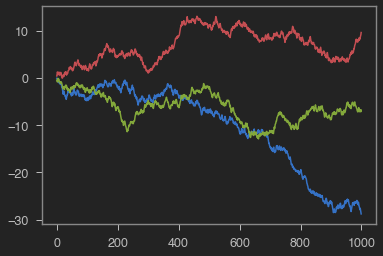

(200, 2, 5) (200,)


In [ ]:
n_vars = 3

t = (np.random.rand(1000, n_vars) - .5).cumsum(0)
print(t.shape)
plt.plot(t)
plt.show()
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=[0,1], get_y=2)(t)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

In [ ]:
wl = 5
n_vars = 3

t = (np.random.rand(100, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, horizon=0, get_x=columns[:-1], get_y='target')(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 3)


,var_0,var_1,target
0,-0.231978,0.073219,0.133267
1,-0.467310,0.393773,-0.145846
2,-0.596566,0.206710,-0.166565
3,-0.685837,-0.234336,0.033277
4,-1.134745,0.107733,0.232557
...,...,...,...
95,-5.460119,-2.531420,2.144726
96,-5.651039,-2.287359,2.137362
97,-5.768159,-2.291407,2.056863
98,-5.335280,-1.887203,1.920184


(96, 2, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,var_0,var_1,var_2,var_3,target
0,0.193542,0.324859,-0.439214,0.427244,-0.410780
1,-0.078862,0.147746,-0.681942,0.380159,-0.104505
2,0.355172,0.365881,-0.432425,0.725684,-0.585669
3,0.602106,0.783386,-0.789050,0.928138,-1.006820
4,1.053169,1.243051,-0.817524,1.250919,-0.912237
...,...,...,...,...,...
95,2.177680,0.023329,-6.360521,-1.917417,1.037216
96,2.300952,0.452308,-6.840108,-2.008926,1.506521
97,2.645694,0.470447,-7.125660,-2.367854,1.572651
98,2.149996,0.699077,-6.795947,-2.094254,1.527571


(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5

t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,0.037698,-0.105557,-0.070702,-0.264796,-0.357515,-0.819990,-1.112825,-1.390167,-1.604567,-1.996689,...,-3.339660,-2.987781,-2.724810,-2.304022,-2.054406,-1.834835,-2.096242,-2.543453,-2.119549,-2.443395
var_1,-0.388118,-0.511601,-0.683879,-0.655155,-0.893629,-0.985884,-1.001955,-1.314903,-0.819247,-0.822493,...,3.212981,3.117866,2.661699,2.220735,1.950584,1.890528,1.920944,2.275084,2.149109,1.854139
var_2,-0.308623,0.083552,0.479843,0.585789,0.977275,1.349887,0.961452,1.330115,1.400043,0.904188,...,1.424624,1.729130,1.924212,1.935811,2.364440,1.927599,1.804408,2.148883,1.710551,1.435207
var_3,0.246121,0.426827,0.216639,0.493663,0.570160,0.930049,1.162472,0.753258,0.294986,0.608925,...,2.294901,2.730669,2.846544,2.717469,3.056577,2.625756,3.024835,3.197316,3.060408,2.947579
target,0.159147,0.424405,0.127447,0.538327,0.421830,-0.036106,0.443024,0.481708,0.974320,0.614118,...,2.356571,2.853381,3.046959,3.066095,2.986333,2.648783,2.965836,3.152990,3.433206,3.860239


(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.016014,-0.193834,-0.339561,-0.152544,-0.588451,-0.564479,-0.690441,-0.282655,-0.241216,-0.682800,...,3.219176,3.295780,3.355775,3.667801,3.230419,2.906828,3.121994,3.049943,2.612439,2.622993
var_1,0.357825,0.824825,0.458150,0.194628,0.592070,0.920952,0.511189,0.692682,0.312670,0.268487,...,-1.814576,-1.716377,-2.153985,-2.628978,-2.918884,-2.823221,-3.041023,-2.706213,-2.371573,-2.359086
var_2,-0.483149,-0.827982,-0.673997,-0.428824,-0.670703,-0.685619,-0.860849,-0.449036,-0.510888,-0.823725,...,-0.062656,0.363169,0.444994,0.628416,0.731142,0.977617,1.472593,1.450841,1.077101,1.041675
var_3,0.486444,0.723155,0.466988,0.840850,0.350828,0.614538,0.685082,1.148884,0.774725,0.924849,...,-2.383779,-2.830171,-2.995482,-3.248839,-2.842244,-2.443995,-2.590630,-3.026265,-2.920851,-3.382990
target,-0.119082,-0.298034,-0.275854,-0.273088,0.047840,-0.271275,0.046206,0.126967,-0.256164,0.098582,...,0.581407,0.919777,1.228744,1.552627,1.515195,1.387484,1.186082,0.794743,0.598146,0.211030


(20, 4, 5) (20,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
splits = TrainValidTestSplitter(valid_size=.2, shuffle=False)(y)
X.shape, y.shape, splits

(100, 5)


,var_0,var_1,var_2,var_3,target
0,-0.131496,0.070269,0.412551,0.189576,-0.153332
1,-0.167632,0.465777,-0.060265,-0.011191,0.296560
2,0.116138,0.897045,0.097421,0.445967,-0.144950
3,0.226665,0.652027,0.147494,0.820836,-0.241105
4,0.000226,0.283581,0.024860,1.108368,-0.089519
...,...,...,...,...,...
95,3.773133,0.422684,-2.050712,1.405679,1.166771
96,3.457718,0.269076,-2.312521,1.252371,1.210241
97,3.378739,-0.203600,-2.188210,1.495613,0.795452
98,3.592979,-0.389619,-1.935572,1.903787,1.111848


((96, 4, 5),
 (96,),
 ((#77) [0,1,2,3,4,5,6,7,8,9...], (#19) [77,78,79,80,81,82,83,84,85,86...]))

In [ ]:
#export
def SlidingWindowPanel(window_len:int, unique_id_cols:list, stride:Union[None, int]=1, start:int=0, get_x:Union[None, int, list]=None,  
                       get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:Union[int, list]=1, seq_first:bool=True, 
                       sort_by:Optional[list]=None, ascending:bool=True, check_leakage:bool=True, return_key:bool=False, verbose:bool=True):

    """
    Applies a sliding window to a pd.DataFrame.
    
    Args:
        window_len      = length of lookback window
        unique_id_cols  = pd.DataFrame columns that will be used to identify a time series for each entity.
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict:
                            * 0 for last step in each sub-window. 
                            * n > 0 for a range of n future steps (1 to n). 
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y           = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created.
        y_func          = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        check_leakage   = checks if there's leakage in the output between X and y
        return_key      = when True, the key corresponsing to unique_id_cols for each sample is returned
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """
    
    sort_by = unique_id_cols + (sort_by if sort_by is not None else [])
    
    def _SlidingWindowPanel(df):
        
        df.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
        unique_id_values = df[unique_id_cols].drop_duplicates().values
        _x = []
        _y = []
        _key = []
        for v in progress_bar(unique_id_values, display=verbose, leave=False):
            x_v, y_v = SlidingWindow(window_len, stride=stride, start=start, get_x=get_x, get_y=get_y, y_func=y_func, 
                                     horizon=horizon, seq_first=seq_first, check_leakage=check_leakage)(df[(df[unique_id_cols].values == v).sum(axis=1) == len(v)])                                
            if x_v is not None and len(x_v) > 0: 
                _x.append(x_v)
                if return_key: _key.append([v.tolist()] * len(x_v))
                if y_v is not None and len(y_v) > 0: _y.append(y_v)
            else: pv(f'cannot use {unique_id_cols} = {v} due to not having enough records', verbose)

        X = np.concatenate(_x)
        if _y != []:
            y = np.concatenate(_y)
            for d in np.arange(1, y.ndim)[::-1]:
                if y.shape[d] == 1: y = np.squeeze(y, axis=d)
        else: y = None
        if return_key: 
            key = np.concatenate(_key)
            if key.ndim == 2 and key.shape[-1] == 1: key = np.squeeze(key, -1)
            if return_key: return X, y, key
        else: return X, y
        
    return _SlidingWindowPanel

SlidingWindowPanelSplitter = SlidingWindowPanel

In [ ]:
samples = 100_000
wl = 5
n_vars = 10

t = (torch.stack(n_vars * [torch.arange(samples)]).T * tensor([10**i for i in range(n_vars)]))
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
df['time'] = np.arange(len(t))
df['device'] = 0
df['target'] = np.random.randint(0, 2, len(df))
df2 = df.copy()
df3 = df.copy()
cols = ['var_0', 'var_1', 'var_2', 'device', 'target']
df2[cols] = df2[cols] + 1
df3[cols] = df3[cols] + 2
df2 = df2.loc[:3]
df['region'] = 'A'
df2['region'] = 'A'
df3['region'] = 'B'
df = df.append(df2).append(df3).reset_index(drop=True)
df['index'] = np.arange(len(df))
df = df.sample(frac=1).reset_index(drop=True)
display(df.head())
df.shape

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,time,device,target,region,index
0,9152,91502,915002,9150000,91500000,915000000,9150000000,91500000000,915000000000,9150000000000,9150,2,3,B,109154
1,89744,897440,8974400,89744000,897440000,8974400000,89744000000,897440000000,8974400000000,89744000000000,89744,0,1,A,89744
2,54719,547172,5471702,54717000,547170000,5471700000,54717000000,547170000000,5471700000000,54717000000000,54717,2,3,B,154721
3,30152,301520,3015200,30152000,301520000,3015200000,30152000000,301520000000,3015200000000,30152000000000,30152,0,1,A,30152
4,34153,341512,3415102,34151000,341510000,3415100000,34151000000,341510000000,3415100000000,34151000000000,34151,2,3,B,134155


(200004, 15)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=False)(df)
X.shape, y.shape

cannot use ['device'] = [1] due to not having enough records


((199992, 10, 5), (199992,))

In [ ]:
X, y, key = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                               horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=True)(df)
X.shape, y.shape, key.shape

cannot use ['device'] = [1] due to not having enough records


((199992, 10, 5), (199992,), (199992,))

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

cannot use ['device', 'region'] = [1 'A'] due to not having enough records


((199992, 10, 5), (199992,))

In [ ]:
# y_func must be a function applied to axis=1!
def y_max(o): return np.max(o, axis=1)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          y_func=y_max, horizon=5, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

cannot use ['device', 'region'] = [1 'A'] due to not having enough records


((199982, 10, 5), (199982,))

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.core.ipynb.
Converted 011_callback.noisy_student.ipynb.
Converted 012_callback.gblend.ipynb.
Converted 013_callback.TSBERT.ipynb.
Converted 014_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
